# Imports

In [1]:
from pyabc import (ABCSMC, Distribution, RV,
                   History, Model,
                   ModelResult, MedianEpsilon)
from pyabc.transition import MultivariateNormalTransition
from pyabc.visualization import plot_kde_matrix
from pyabc.sampler import MulticoreEvalParallelSampler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'
import os
import tempfile
import math
import pandas as pd
import scipy as sp
import numpy as np
import subprocess
from io import BytesIO

from pyabc_custom import MyokitSimulation
from prangle_distance import PrangleDistance,PranglePopulationSize,PrangleEpsilon

In [10]:
# Loading bar for long notebook loops
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

# Get experimental measurements

In [2]:
myokit_python = ('/scratch/cph211/miniconda3/envs' +
                 '/ion_channel_ABC/bin/python')
args = [myokit_python, 'get_measurements.py']
args.append('iha')
re = subprocess.run(args, stdout=subprocess.PIPE)
measurements = pd.read_table(BytesIO(re.stdout),
                             delim_whitespace=True,
                             header=0, index_col=False)
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']
errs = measurements.to_dict()['errs']

# Set limits and generate uniform initial priors

In [3]:
limits = dict(g_ha=(0, 0.1),
              k_yss1=(0, 100),
              k_yss2=(0, 10),
              k_ytau1=(0, 10),
              k_ytau2=(0, 1),
              k_ytau3=(0, 100),
              k_ytau4=(0, 100),
              k_ytau5=(0, 1),
              k_ytau6=(0, 100),
              k_ytau7=(0, 100),
              k_i_haNa=(0, 1))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Define ABC parameters and initialise database

In [4]:
def model_measure(df):
    keys = range(len(df))
    return dict(zip(keys, df.y))
myokit_model = MyokitSimulation('iha', measure_fn=model_measure)
myokit_model.sample({})

In [7]:
db_path = ('sqlite:///' + 
           os.path.join(tempfile.gettempdir(), "hl-1_iha.db"))
print(db_path)

In [8]:
abc = ABCSMC(models=myokit_model,
             parameter_priors=prior,
             distance_function=PrangleDistance(
                 exp_map=exp,
                 alpha=0.5,
                 delta=0.5,
                 adapt=False),
             population_size=PranglePopulationSize(
                 500, alpha=0.5,
                 adapt=True,
                 mean_cv=0.5,
                 min_population_size=200,
                 max_population_size=5000),
             eps=PrangleEpsilon(100, alpha=0.5))

In [9]:
abc_id = abc.new(db_path, obs)

INFO:Epsilon:initial epsilon is 100
INFO:History:Start <ABCSMC(id=1, start_time=2018-06-26 15:59:58.737516, end_time=None)>


In [10]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=20)

INFO:ABC:t:0 M eps:[100]
INFO:ABC:t:0 N eps:8.733058084545895
INFO:ABC:N population size: 500
INFO:ABC:t:1 M eps:[100.           8.73305808]
INFO:Adaptation:Change nr particles 500 -> 5000
INFO:ABC:t:1 N eps:7.044966436696645
INFO:ABC:N population size: 5000
INFO:ABC:t:2 M eps:[100.           8.73305808   7.04496644]
INFO:Adaptation:Change nr particles 5000 -> 5000
INFO:ABC:t:2 N eps:6.114874492631602
INFO:ABC:N population size: 5000
INFO:ABC:t:3 M eps:[100.           8.73305808   7.04496644   6.11487449]
INFO:Adaptation:Change nr particles 5000 -> 5000
INFO:ABC:t:3 N eps:5.465648689599159
INFO:ABC:N population size: 5000
INFO:ABC:t:4 M eps:[100.           8.73305808   7.04496644   6.11487449   5.46564869]
INFO:Adaptation:Change nr particles 5000 -> 5000
INFO:ABC:t:4 N eps:4.884434120151335
INFO:ABC:N population size: 5000
INFO:ABC:t:5 M eps:[100.           8.73305808   7.04496644   6.11487449   5.46564869
   4.88443412]
INFO:Adaptation:Change nr particles 5000 -> 5000
INFO:ABC:t:5 N e

In [16]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=5)

INFO:ABC:t:24 M eps:[100.           8.73305808   7.04496644   6.11487449   5.46564869
   4.88443412   4.34170285   3.90456896   3.49315464   3.06129037
   2.71389069   2.40124991   2.13916955   1.9164832    1.73194483
   1.58627176   1.47595407   1.38908903   1.3252806    1.27488223
   1.23581004   1.20862497   1.18443388   1.16585537   1.15218199]
INFO:Adaptation:Change nr particles 2500 -> 5000
INFO:ABC:t:24 N eps:1.1422303458836087
INFO:ABC:N population size: 5000
INFO:ABC:t:25 M eps:[100.           8.73305808   7.04496644   6.11487449   5.46564869
   4.88443412   4.34170285   3.90456896   3.49315464   3.06129037
   2.71389069   2.40124991   2.13916955   1.9164832    1.73194483
   1.58627176   1.47595407   1.38908903   1.3252806    1.27488223
   1.23581004   1.20862497   1.18443388   1.16585537   1.15218199
   1.14223035]
INFO:Adaptation:Change nr particles 5000 -> 5000


KeyboardInterrupt: 

# Results analysis

In [5]:
db_path = 'sqlite:///pyabc-runs/hl-1_iha.db'
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2018-06-26 15:59:58.737516, end_time=2018-06-27 05:40:33.039884)>]

In [6]:
history.id = 1

In [8]:
# Generate parameter samples
n_samples = 50
post_df, post_w = history.get_distribution(m=0)
post_th = post_df.sample(n=n_samples, weights=post_w, replace=True).to_dict(orient='records')

/storage/hhecm/cellrotor/chouston/pyabc/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()


In [51]:
# Generate results samples
from pyabc_custom import simulate

samples = pd.DataFrame({})
for i, th in log_progress(enumerate(post_th), every=1, size=len(post_th)):
    output = None
    while output is None:
        try:
            output = simulate('iha', n_x=None, **th)
        except ValueError:
            output = None
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

In [52]:
# Fit linear line to current-voltage relationship
grouped = samples[samples['exp']==0].groupby('sample')
from scipy.optimize import curve_fit
def fit_linear_line(group):
    def linear_line(x, m, c):
        return m*x + c
    popt, _ = curve_fit(linear_line, group.x, group.y)
    m, c = popt[0], popt[1]
    x_intercept = -c / m
    return (x_intercept, m*1000)
output = grouped.apply(fit_linear_line).apply(pd.Series)

In [54]:
print(output.mean())
print(output.std())

0   -21.007022
1    89.877907
dtype: float64
0    0.566218
1    2.005701
dtype: float64


In [55]:
# Fit of activation to Boltzmann equation
grouped = samples[samples['exp']==1].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1/(1+np.exp((V-Vhalf)/K))
    guess = (-100, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

/scratch/cph211/miniconda3/envs/pyabc/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/scratch/cph211/miniconda3/envs/pyabc/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/scratch/cph211/miniconda3/envs/pyabc/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/scratch/cph211/miniconda3/envs/pyabc/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/scratch/cph211/miniconda3/envs/pyabc/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/scratch/cph211/miniconda3/env

In [64]:
# Values of time constants at specific voltages
grouped = samples[samples['exp']==2].groupby('sample')
def get_tau(group):
    tau_60 = float(group[group.x==-60].y)
    tau_130 = float(group[group.x==-130].y)
    return (tau_60, tau_130)
output = grouped.apply(get_tau).apply(pd.Series)

In [66]:
print(output.mean())
print(output.std())

0    7.036835
1    0.104146
dtype: float64
0    0.110988
1    0.012704
dtype: float64


/storage/hhecm/cellrotor/chouston/pyabc/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()


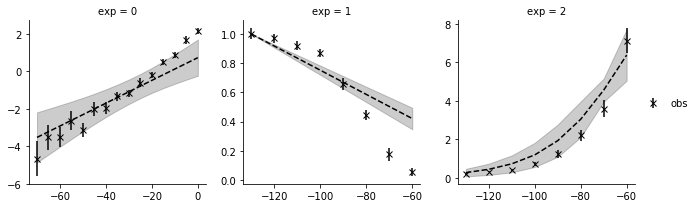

In [45]:
from visualization_custom import plot_sim_results
g = plot_sim_results(history, 'iha', n_samples=5, obs=measurements, n_x=None)

# Old results analysis below this line

In [5]:
db_path = 'sqlite:///pyabc-runs/hl-1_iha.db'
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2018-06-26 15:59:58.737516, end_time=2018-06-27 05:40:33.039884)>]

/tmp/chouston/miniconda3/envs/pyabc/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


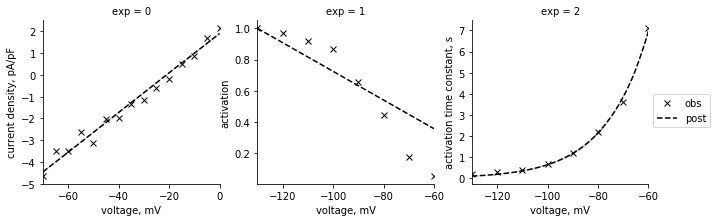

In [7]:
from visualization_custom import plot_sim_results
g = plot_sim_results(history, 'iha', n_samples=10, obs=measurements, original=False)
xlabels = ["voltage, mV", "voltage, mV", "voltage, mV"]
ylabels = ["current density, pA/pF", "activation", "activation time constant, s"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)
plt.savefig('iha_results.pdf', format='pdf', dpi=1000)

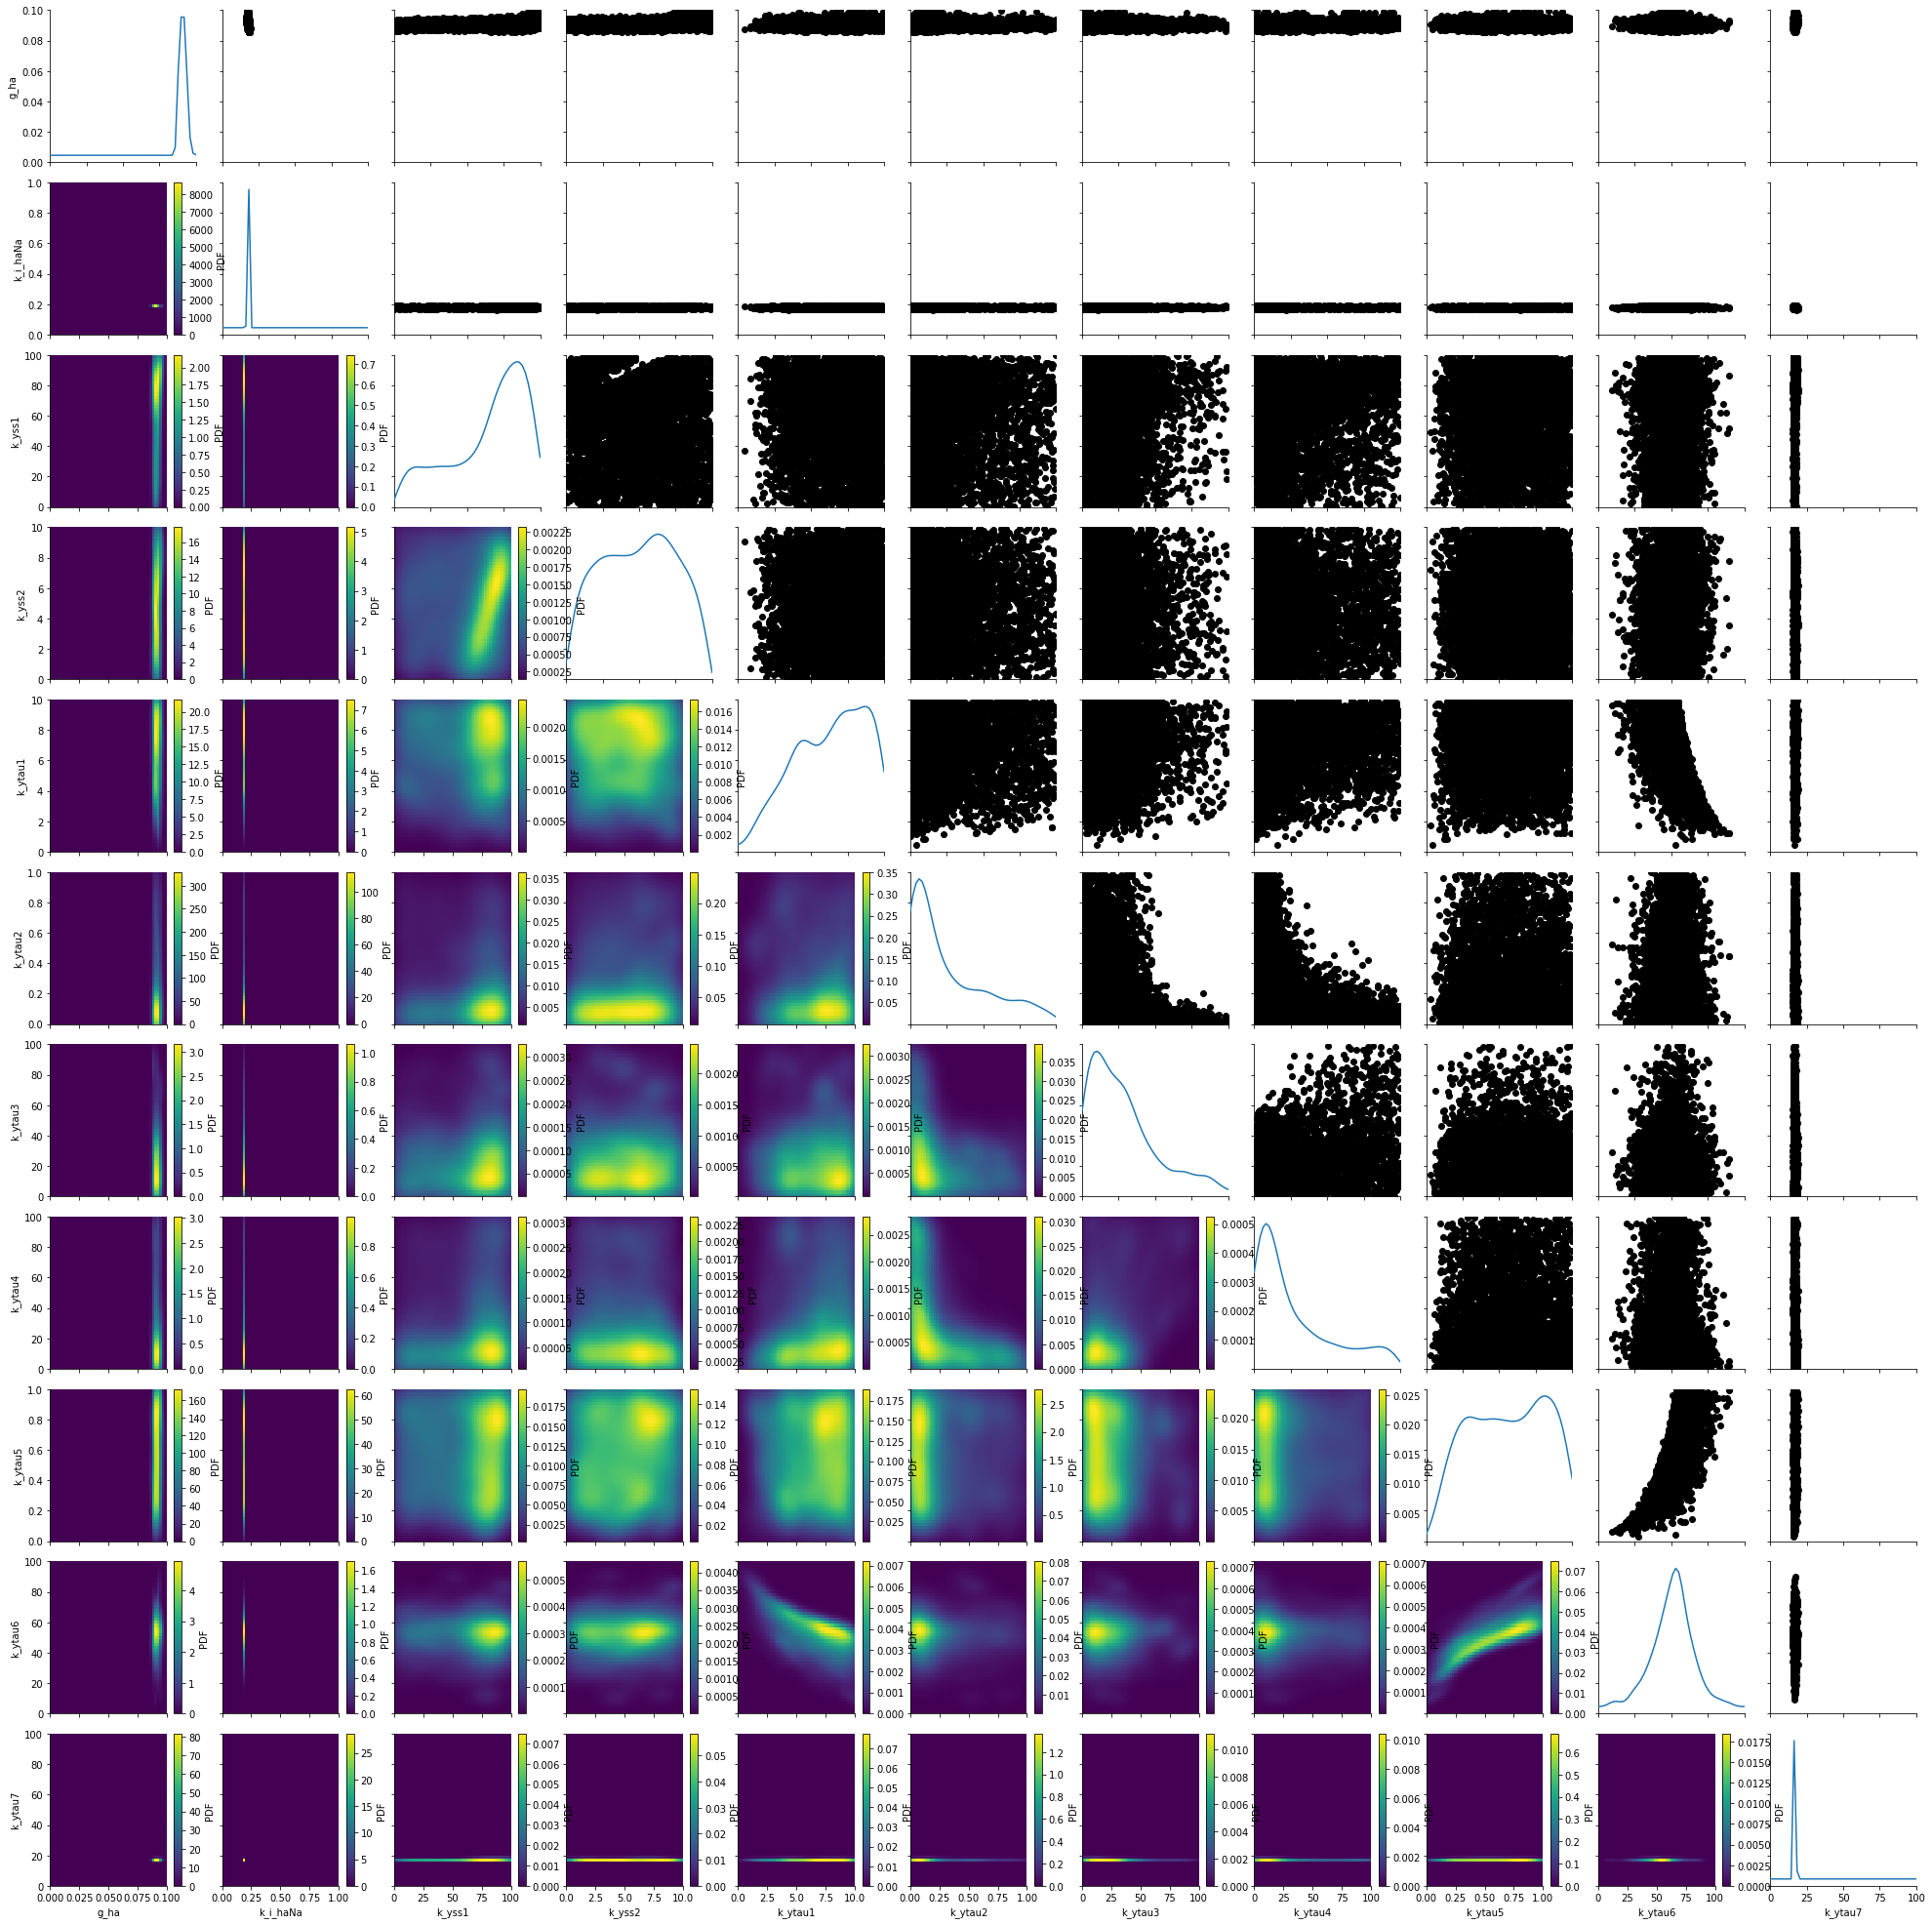

In [18]:
df, w = history.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits)

In [ ]:
db_path = 'sqlite:///pyabc-runs/hl-1_iha.db'
history = History(db_path)
history.all_runs()

In [20]:
df, w = history.get_distribution(m=0)
df['wt'] = w
print("Mean")
for key in limits.keys():
    print(key, ":", sum(df[key] * df.wt))
print("Min")
for key in limits.keys():
    print(key, ":", min(df[key]))
print("Max")
for key in limits.keys():
    print(key, ":", max(df[key]))

Mean
g_ha : 0.0909545290112378
k_yss1 : 60.673485181620215
k_yss2 : 4.973963743690542
k_ytau1 : 6.388599333218339
k_ytau2 : 0.2682961466391644
k_ytau3 : 26.874532037143872
k_ytau4 : 30.739228218502273
k_ytau5 : 0.5616847005125513
k_ytau6 : 50.9967573954618
k_ytau7 : 16.754660871957018
k_i_haNa : 0.17896991496636958
Min
g_ha : 0.08518742054378937
k_yss1 : 0.0785671050909329
k_yss2 : 0.005195917176980369
k_ytau1 : 0.45551704369577584
k_ytau2 : 5.020649955791989e-06
k_ytau3 : 0.006130500033115993
k_ytau4 : 0.2347219611373852
k_ytau5 : 0.03144217050833935
k_ytau6 : 9.28845711771259
k_ytau7 : 15.033165684005471
k_i_haNa : 0.1628378100820481
Max
g_ha : 0.09991955215255488
k_yss1 : 99.99986277988837
k_yss2 : 9.98918710210725
k_ytau1 : 9.99774507962944
k_ytau2 : 0.9979365943204859
k_ytau3 : 98.87417426649652
k_ytau4 : 99.97183153931509
k_ytau5 : 0.9993087488619901
k_ytau6 : 89.65894229560229
k_ytau7 : 19.390881127410935
k_i_haNa : 0.19436511380204616


run
0     AxesSubplot(0.125,0.125;0.775x0.755)
1     AxesSubplot(0.125,0.125;0.775x0.755)
2     AxesSubplot(0.125,0.125;0.775x0.755)
3     AxesSubplot(0.125,0.125;0.775x0.755)
4     AxesSubplot(0.125,0.125;0.775x0.755)
5     AxesSubplot(0.125,0.125;0.775x0.755)
6     AxesSubplot(0.125,0.125;0.775x0.755)
7     AxesSubplot(0.125,0.125;0.775x0.755)
8     AxesSubplot(0.125,0.125;0.775x0.755)
9     AxesSubplot(0.125,0.125;0.775x0.755)
10    AxesSubplot(0.125,0.125;0.775x0.755)
11    AxesSubplot(0.125,0.125;0.775x0.755)
12    AxesSubplot(0.125,0.125;0.775x0.755)
13    AxesSubplot(0.125,0.125;0.775x0.755)
14    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

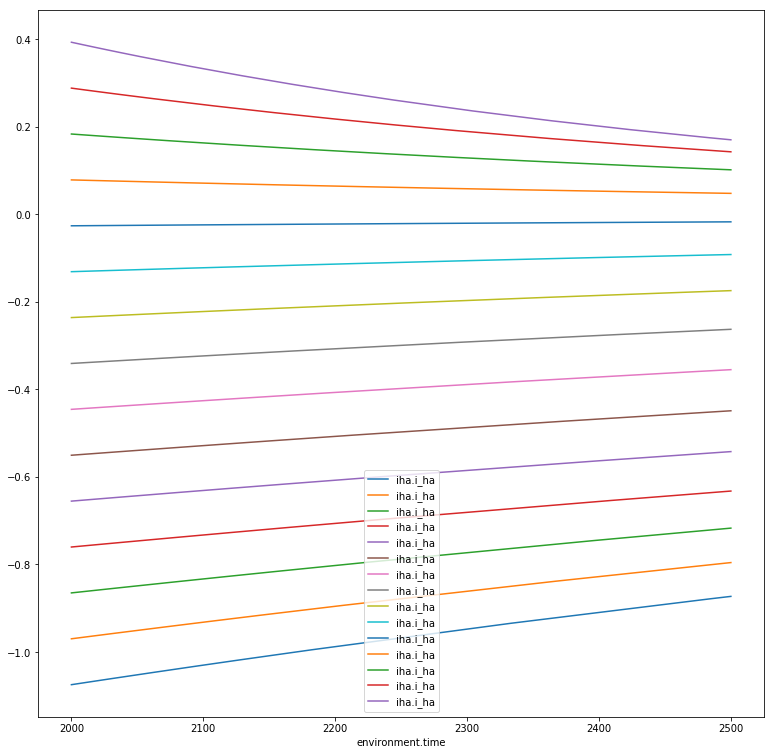

In [21]:
from pyabc_custom import simulate
out = simulate('iha', experiment=0, logvars=['environment.time', 'iha.i_ha'])
fig,ax = plt.subplots(figsize=(13,13))
out.groupby("run").plot(x="environment.time", y="iha.i_ha",ax=ax)